# Perceptrón Multicapa (MLP): de la intuición a la implementación

## Objetivo del Notebook

El propósito de este cuaderno es **comprender a fondo** el funcionamiento de un **perceptrón multicapa (MLP, *Multi-Layer Perceptron*)**, una de las arquitecturas más fundamentales de las redes neuronales artificiales.

En particular, nos proponemos:

1. **Entender qué es un MLP**  
   - Cómo se construye como una función matemática que transforma entradas en salidas mediante capas de neuronas conectadas.  
   - Qué papel juegan las capas de entrada, ocultas y salida.  

2. **Analizar el proceso de *forward propagation***  
   - Cómo fluyen los datos desde la entrada hasta la salida a través de transformaciones lineales y funciones de activación.  
   - Ver paso a paso la propagación de un ejemplo concreto.  

3. **Aprender cómo se entrena un MLP con *backpropagation***  
   - Definir una función de pérdida y calcular sus gradientes respecto a los parámetros (pesos y sesgos).  
   - Aplicar el **descenso de gradiente** para ajustar los parámetros de la red y mejorar la aproximación de la función objetivo.  
   - Introducir el rol de los lotes (*batches*) y las épocas (*epochs*) en el entrenamiento.  

4. **Probar una versión compacta con Keras**  
   - Reutilizar el mismo problema planteado para comprobar cómo una librería de alto nivel abstrae el proceso de propagación y entrenamiento.  
   - Comparar los resultados y reflexionar sobre qué partes se automatizan en un framework moderno.  

En resumen, el objetivo es **pasar de lo básico a lo práctico**: entender los fundamentos matemáticos y computacionales de los MLPs, implementarlos desde cero con `numpy` y finalmente validar la comprensión utilizando **Keras** como herramienta de alto nivel.



## 1. De ajustar curvas a redes neuronales

Entrenar una red neuronal es, esencialmente, **ajustar una función** a datos de entrada/salida. Dada una muestra $\{(x^{(i)}, y^{(i)})\}_{i=1}^N$, buscamos una función paramétrica $f_\theta$ tal que $f_\theta(x^{(i)}) \approx y^{(i)}$ para todo $i$.

**Analogía** (ajuste de curvas):
- En ajuste polinómico, elegimos un grado $d$ y encontramos coeficientes que minimizan el error.
- En redes neuronales, elegimos una **arquitectura** (capas y neuronas) y aprendemos **pesos y sesgos** que minimizan una **función de pérdida**.

Formalmente, el entrenamiento consiste en encontrar los parámetros $\theta$ de la red $f_\theta$ que minimicen la función de pérdida $\mathcal{L}$ (que cuantifica el error entre las predicciones $f_\theta(x^{(i)})$ y los valores reales $y^{(i)}$):
$$
\min_{\theta} \ \frac{1}{N}\sum_{i=1}^N \mathcal{L}\big(f_\theta(x^{(i)}), y^{(i)}\big).
$$
Para ello, optimizamos $\theta$ mediante descenso por gradiente (u otros métodos basados en gradientes).



## 2. Arquitectura de un perceptrón multicapa (MLP)

Una red neuronal *feed-forward* típica tiene:
- **Capa de entrada**: recibe $x \in \mathbb{R}^{d_{in}}$ (valores del dominio).
- **Capas ocultas**: transformaciones intermedias no lineales.
- **Capa de salida**: produce $f_\theta(x)$ (imagen de la función).

Por ejemplo, un **MLP** con una capa oculta se puede escribir como
$$
\begin{aligned}
z^{[1]} &= W^{[1]}x + b^{[1]}, \quad h^{[1]} = \sigma^{[1]}\!\left(z^{[1]}\right), \\
z^{[2]} &= W^{[2]}h^{[1]} + b^{[2]}, \quad \hat{y} = \sigma^{[2]}\!\left(z^{[2]}\right),
\end{aligned}
$$
donde $W^{[\ell]}$, $b^{[\ell]}$ y $\sigma^{[\ell]}$ son los **pesos, sesgos** y **funciones de activación** asociados a la capa $\ell$.

### Notación matricial general

De forma general, para un conjunto de datos $X \in \mathbb{R}^{N \times d_{in}}$ de $N$ ejemplos, y una red con $L$ capas,
se define de manera recursiva:

$$
\begin{aligned}
Z^{[\ell]} &= H^{[\ell-1]} (W^{[\ell]})^\top + \mathbf{1}(b^{[\ell]})^\top, \\
H^{[\ell]} &= \sigma^{[\ell]}\!\left(Z^{[\ell]}\right), \qquad \ell = 1, \dots, L,
\end{aligned}
$$

donde:
- $H^{[0]} = X$ (la entrada),
- $W^{[\ell]} \in \mathbb{R}^{d_\ell \times d_{\ell-1}}$ son los pesos,
- $b^{[\ell]} \in \mathbb{R}^{d_\ell}$ los sesgos,
- $\mathbf{1} \in \mathbb{R}^{N \times 1}$ es un vector de unos,
- y $\sigma^{[\ell]}$ es la función de activación de la capa $\ell$.

Finalmente, la salida de la red es:
$$
\hat{Y} = H^{[L]} = f_\theta(X).
$$



## 3. Forward propagation (propagación hacia delante)

El **forward propagation** es el proceso de **evaluar** la red $f_\theta$ sobre un conjunto de entradas, aplicando **en cadena** (capa a capa) transformaciones **afines** y **no lineales**. Es decir, obtenemos la predicción $\hat{Y} = H^{[L]}$. En la práctica, este proceso:

1) **agrega evidencia lineal** con $Z^{[\ell]}$,  
2) **introduce no linealidad** con $\sigma^{[\ell]}$,  
3) **propaga** activaciones hasta la salida.

### Ejemplo
Aproximar $z = \sin(x)\cos(y)$

**Objetivo.** Aproximar la función escalar $f(x,y) \approx \sin(x)\cos(y)$ sobre el dominio $x,y \in [-\pi, \pi]$.  
**Arquitectura.** Usaremos un MLP con:
- Entrada: $d_{in}=2$ (las variables $x,y$),
- Dos capas ocultas: $d_1=32$, $d_2=16$ con activación $\tanh$,
- Salida: $d_3=1$ con activación identidad (regresión).

A continuación inicializamos los parámetros **al azar** y ejecutamos el *forward* **paso a paso**, imprimiendo formas y ejemplos intermedios. *Nota:* como la red no está entrenada, la salida es arbitraria.

In [1]:
import numpy as np

# -----------------------------
# Datos de ejemplo: z = sin(x)*cos(y) en [-pi, pi]^2
# -----------------------------
rng = np.random.default_rng(123)
N = 2000
x = rng.uniform(-np.pi, np.pi, size=(N, 1))
y = rng.uniform(-np.pi, np.pi, size=(N, 1))
X = np.hstack([x, y])                 # (N, 2)
Z_true = np.sin(x) * np.cos(y)        # (N, 1)  -- solo como referencia futura (no se usa aquí para entrenar)

# -----------------------------
# Definición de activaciones
# -----------------------------
def tanh(x):
    return np.tanh(x)

def identity(x):
    return x

# -----------------------------
# Arquitectura del MLP
# dims = [d_in, d1, d2, d_out]
# -----------------------------
dims = [2, 32, 16, 1]
L = len(dims) - 1  # número de capas con parámetros

activations = {
    1: (tanh, "tanh"),
    2: (tanh, "tanh"),
    3: (identity, "identity"),  # salida para regresión
}

# -----------------------------
# Inicialización (Glorot normal)
# W^[l] ∈ R^{d_l × d_{l-1}}, b^[l] ∈ R^{d_l}
# -----------------------------
def glorot_normal(fan_in, fan_out, rng):
    std = np.sqrt(2.0 / (fan_in + fan_out))
    return rng.normal(loc=0.0, scale=std, size=(fan_out, fan_in))

params = {}
for l in range(1, L + 1):
    fan_in, fan_out = dims[l-1], dims[l]
    params[f"W{l}"] = glorot_normal(fan_in, fan_out, rng)
    params[f"b{l}"] = np.zeros(fan_out, dtype=float)

# -----------------------------
# Forward propagation con trazas (paso a paso)
# SOLO para el primer ejemplo (N=1) para ver valores claros
# -----------------------------
def forward_debug_one(X, params, activations):
    # Tomamos el primer ejemplo: vector de entrada (1, d_in)
    x0 = X[0:1, :]
    print(f"Ejemplo de entrada H^[0] = {x0}")

    H_prev = x0
    caches = []

    for l in range(1, L + 1):
        W = params[f"W{l}"]   # (d_l, d_{l-1})
        b = params[f"b{l}"]   # (d_l,)
        sigma, sigma_name = activations[l]

        # Cálculo afín
        Z = H_prev @ W.T + b  # (1, d_l)
        H = sigma(Z)          # (1, d_l)

        print(f"\nCapa {l}:")
        print(f"  W^{l} shape = {W.shape}, b^{l} shape = {b.shape}")
        print(f"  Z^{l} = H^[{l-1}] @ (W^{l})^T + b^{l} -> {Z.shape}")
        print(f"  Valores Z^{l}:\n{Z}")
        print(f"  H^{l} = {sigma_name}(Z^{l}) -> {H.shape}")
        print(f"  Valores H^{l}:\n{H}")

        caches.append((H_prev, W, b, Z, H))
        H_prev = H

    Yhat = H_prev
    print(f"\nSalida final H^[{L}] = \\hat{{y}} con shape {Yhat.shape}")
    print(f"Predicción de la red (no entrenada): {Yhat.ravel()}")
    return Yhat, caches

# Ejecutar forward SOLO para el primer ejemplo
_ = forward_debug_one(X, params, activations)

Ejemplo de entrada H^[0] = [[ 1.14575055 -0.95681972]]

Capa 1:
  W^1 shape = (32, 2), b^1 shape = (32,)
  Z^1 = H^[0] @ (W^1)^T + b^1 -> (1, 32)
  Valores Z^1:
[[ 0.16084875  0.34573671  0.26837893 -0.0674718  -0.37752079 -0.21943166
  -0.57076363  0.0159666  -0.38763524  0.10335938 -0.47559531  0.04943612
  -0.02325274  0.54474909  0.58382903 -0.36336363  0.56466757  0.07871529
  -0.24572811 -0.07253903 -0.0423592  -0.53239456 -0.2233143   0.49481522
   0.49630459 -0.76836315  0.1232943  -0.27290119 -0.42487725 -0.06874244
  -0.32822556 -0.0454203 ]]
  H^1 = tanh(Z^1) -> (1, 32)
  Valores H^1:
[[ 0.15947578  0.33258924  0.26211578 -0.0673696  -0.36055248 -0.2159763
  -0.51591987  0.01596524 -0.3693198   0.10299288 -0.44270912  0.04939589
  -0.02324855  0.49657442  0.52544288 -0.34817337  0.51143236  0.07855312
  -0.24089884 -0.07241207 -0.04233388 -0.48720938 -0.21967471  0.45802985
   0.45920596 -0.64597664  0.12267332 -0.26632233 -0.40103128 -0.06863437
  -0.31692546 -0.04538909]]


## 4. *Backward propagation* (retropropagación) y entrenamiento con descenso del gradiente

Una vez que realizamos el **forward propagation** y obtenemos una predicción $\hat{Y}$ para un lote de datos, debemos comparar el resultado con los valores reales $Y$. Esa comparación se hace mediante una **función de pérdida**, que mide el error entre la predicción y la realidad.

En nuestro ejemplo de regresión, donde queremos aproximar:
$$
z = \sin(x)\cos(y),
$$
utilizaremos el **error cuadrático medio (MSE)**:
$$
\mathcal{L}(\hat{Y},Y) = \frac{1}{N} \sum_{i=1}^N \big(\hat{y}^{(i)} - y^{(i)}\big)^2.
$$

El objetivo de la retropropagación es **calcular los gradientes** de la pérdida respecto a los parámetros $(W^{[\ell]}, b^{[\ell]})$, y luego actualizarlos en la dirección que minimice la pérdida mediante **descenso del gradiente**:
$$
W^{[\ell]} \leftarrow W^{[\ell]} - \eta \,\frac{\partial \mathcal{L}}{\partial W^{[\ell]}}, \qquad
b^{[\ell]} \leftarrow b^{[\ell]} - \eta \,\frac{\partial \mathcal{L}}{\partial b^{[\ell]}}.
$$

El parámetro $\eta$ (learning rate) controla el tamaño de los pasos en la actualización de los pesos. Con valores típicos entre $10^{-5}$ y $0.1$, su elección es crucial: un $\eta$ demasiado grande causa oscilaciones o divergencia, mientras que uno demasiado pequeño ralentiza el entrenamiento o estanca el modelo en mínimos locales. En la práctica, suele ajustarse experimentalmente o mediante optimizadores adaptativos como Adam.

### *Batch size* y épocas: eficiencia y convergencia  

En la práctica, los parámetros de la red **no se actualizan después de procesar todo el dataset** (*batch gradient descent*), ni ejemplo por ejemplo (*stochastic gradient descent*), sino en **lotes (*batches*)** de tamaño intermedio. Esto se conoce como **mini-batch gradient descent** y equilibra eficiencia y estabilidad:  

1. **¿Por qué usar batches?**  
   - **Tamaño = 1 (SGD puro)**:  
     - *Ventaja*: Actualizaciones frecuentes (rápido progreso inicial).  
     - *Desventaja*: Alta varianza en los gradientes (convergencia ruidosa o inestable).  
   - **Tamaño = N (todo el dataset)**:  
     - *Ventaja*: Gradientes precisos (convergencia suave).  
     - *Desventaja*: Lento por cálculo completo en cada paso (ineficiente para datasets grandes).  
   - **Mini-batch (tamaño $m \ll N$)**:  
     - Balancea velocidad y estabilidad. Los tamaños típicos son potencias de 2 (ej. 32, 64, 128), elegidos por compatibilidad con hardware.  

2. **Épocas y recorrido completo**:  
   Una **época** corresponde a un **paso completo por todo el dataset**, dividido en $N/m$ batches. Por ejemplo:  
   - Dataset de 10,000 ejemplos + batch size = 100 → 100 batches/época.  
   El entrenamiento requiere **múltiples épocas** porque:  
   - Los gradientes de mini-batches solo aproximan la dirección óptima (necesitan iteraciones para refinar).  
   - Permite a la red "ver" los datos varias veces y ajustar pesos progresivamente.  

### Ecuaciones matriciales de *backpropagation* (red general y nuestro caso)
Recordemos la notación de *forward* por lotes:
$$
Z^{[\ell]} = H^{[\ell-1]}(W^{[\ell]})^\top + \mathbf{1}(b^{[\ell]})^\top,
\qquad
H^{[\ell]} = \sigma^{[\ell]}(Z^{[\ell]}), \quad H^{[0]}=X.
$$

Para MSE la derivada respecto a la **salida** es:
$$
\frac{\partial \mathcal{L}}{\partial H^{[L]}} = \frac{2}{N}\,(H^{[L]} - Y).
$$

Definimos la **señal de error** por capa
$$
\delta^{[\ell]} \;\equiv\; \frac{\partial \mathcal{L}}{\partial Z^{[\ell]}}
\;=\; \frac{\partial \mathcal{L}}{\partial H^{[\ell]}} \odot \sigma'^{[\ell]}\!\left(Z^{[\ell]}\right).
$$

- En **nuestra red** (regresión) la salida usa **identidad**, luego
  $\sigma^{[L]}(z)=z \Rightarrow \sigma'^{[L]}(z)=1$, y
  $$
  \delta^{[L]} = \frac{2}{N}\,(H^{[L]} - Y).
  $$

Retropropagación para $\ell=L-1,\dots,1$:
$$
\delta^{[\ell]} = \big(\delta^{[\ell+1]} W^{[\ell+1]}\big) \odot \sigma'^{[\ell]}\!\left(Z^{[\ell]}\right).
$$

Gradientes de parámetros:
$$
\frac{\partial \mathcal{L}}{\partial W^{[\ell]}} = \big(\delta^{[\ell]}\big)^\top H^{[\ell-1]},
\qquad
\frac{\partial \mathcal{L}}{\partial b^{[\ell]}} = \big(\delta^{[\ell]}\big)^\top \mathbf{1}.
$$

> **Dimensiones**:  
> $X\!\in\!\mathbb{R}^{N\times d_0}$, $W^{[\ell]}\!\in\!\mathbb{R}^{d_\ell\times d_{\ell-1}}$, $b^{[\ell]}\!\in\!\mathbb{R}^{d_\ell}$,  
> $Z^{[\ell]},H^{[\ell]},\delta^{[\ell]}\!\in\!\mathbb{R}^{N\times d_\ell}$.

**Caso concreto (nuestra arquitectura $[2,32,16,1]$ con $\tanh$ en ocultas e identidad en salida):**
$$
\begin{aligned}
\delta^{[3]} &= \tfrac{2}{N}\,(H^{[3]}-Y),\\
\delta^{[2]} &= \big(\delta^{[3]} W^{[3]}\big)\odot \big(1-\tanh^2(Z^{[2]})\big),\\
\delta^{[1]} &= \big(\delta^{[2]} W^{[2]}\big)\odot \big(1-\tanh^2(Z^{[1]})\big),\\
\frac{\partial \mathcal{L}}{\partial W^{[3]}} &= (\delta^{[3]})^\top H^{[2]},\qquad
\frac{\partial \mathcal{L}}{\partial b^{[3]}} = (\delta^{[3]})^\top \mathbf{1},\\
\frac{\partial \mathcal{L}}{\partial W^{[2]}} &= (\delta^{[2]})^\top H^{[1]},\qquad
\frac{\partial \mathcal{L}}{\partial b^{[2]}} = (\delta^{[2]})^\top \mathbf{1},\\
\frac{\partial \mathcal{L}}{\partial W^{[1]}} &= (\delta^{[1]})^\top H^{[0]},\qquad
\frac{\partial \mathcal{L}}{\partial b^{[1]}} = (\delta^{[1]})^\top \mathbf{1}.
\end{aligned}
$$

In [8]:
from tqdm import tqdm

# -----------------------------
# Función de pérdida MSE
# -----------------------------
def mse_loss(yhat, y):
    return np.mean((yhat - y)**2)

def mse_grad(yhat, y):
    # derivada de MSE respecto a la salida: (2/N)*(yhat - y)
    N = y.shape[0]
    return (2.0 / N) * (yhat - y)

# -----------------------------
# Backward propagation
# -----------------------------
def backward(X, Y, caches, params, activations):
    grads = {}
    L = len([k for k in params.keys() if k.startswith("W")])  # número de capas

    # Paso 1: gradiente inicial desde la pérdida (MSE con identidad en salida)
    H_prev, W_L, b_L, Z_L, H_L = caches[-1]
    dZ = mse_grad(H_L, Y)   # (N, d_out)

    # Backprop capa L
    grads[f"dW{L}"] = dZ.T @ H_prev
    grads[f"db{L}"] = dZ.sum(axis=0)
    dH = dZ @ W_L

    # Capas ocultas hacia atrás
    for l in range(L-1, 0, -1):
        H_prev, W, b, Z, H = caches[l-1]
        sigma, sigma_name = activations[l]

        # derivada de activación
        if sigma_name == "tanh":
            dphi = 1 - np.tanh(Z)**2
        elif sigma_name == "identity":
            dphi = np.ones_like(Z)
        else:
            raise NotImplementedError(f"Derivada no implementada para {sigma_name}")

        dZ = dH * dphi
        grads[f"dW{l}"] = dZ.T @ H_prev
        grads[f"db{l}"] = dZ.sum(axis=0)
        dH = dZ @ W

    return grads

# -----------------------------
# Descenso del gradiente
# -----------------------------
def update_params(params, grads, lr=0.01):
    L = len([k for k in params.keys() if k.startswith("W")])
    for l in range(1, L+1):
        params[f"W{l}"] -= lr * grads[f"dW{l}"]
        params[f"b{l}"] -= lr * grads[f"db{l}"]
    return params

# -----------------------------
# Entrenamiento
# -----------------------------
def iterate_minibatches(X, Y, batch_size, shuffle=True):
    N = X.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    for start_idx in range(0, N, batch_size):
        excerpt = indices[start_idx:start_idx+batch_size]
        yield X[excerpt], Y[excerpt]

# Función de predicción usando la red entrenada
def predict(X, params, activations):
    H_prev = X
    for l in range(1, L+1):
        W, b = params[f"W{l}"], params[f"b{l}"]
        sigma, _ = activations[l]
        Z = H_prev @ W.T + b
        H_prev = sigma(Z)
    return H_prev

# Hiperparámetros
lr = 0.01
epochs = 50
batch_size = 64
loss_hist = []

for ep in range(epochs):
    batch_losses = []

    # Crear un iterador con tqdm para los batches
    batch_iter = iterate_minibatches(X, Z_true, batch_size)
    total_batches = (X.shape[0] + batch_size - 1) // batch_size  # Calcula el número total de batches

    # Usamos tqdm para mostrar el progreso por época
    print(f"\nÉpoca {ep+1}/{epochs}", end=" ")
    for i, (X_batch, Y_batch) in tqdm(enumerate(batch_iter),
                                    total=total_batches,
                                    desc="Progreso",
                                    unit=" batch"):
        # ---- FORWARD ----
        H_prev = X_batch
        caches = []
        for l in range(1, L+1):
            W, b = params[f"W{l}"], params[f"b{l}"]
            sigma, _ = activations[l]
            Z = H_prev @ W.T + b
            H = sigma(Z)
            caches.append((H_prev, W, b, Z, H))
            H_prev = H
        Yhat = H_prev

        # ---- PÉRDIDA ----
        loss = mse_loss(Yhat, Y_batch)
        batch_losses.append(loss)

        # ---- BACKWARD ----
        grads = backward(X_batch, Y_batch, caches, params, activations)

        # ---- UPDATE ----
        params = update_params(params, grads, lr)

    epoch_loss = np.mean(batch_losses)
    loss_hist.append(epoch_loss)
    print(f"  >> Pérdida promedio de la época: {epoch_loss:.6f}")

print("Entrenamiento finalizado.")



Época 1/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1537.77batch/s]


  >> Pérdida promedio de la época: 0.007344

Época 2/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1384.14batch/s]


  >> Pérdida promedio de la época: 0.007878

Época 3/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1091.70batch/s]


  >> Pérdida promedio de la época: 0.007460

Época 4/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1375.96batch/s]


  >> Pérdida promedio de la época: 0.007261

Época 5/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1313.18batch/s]


  >> Pérdida promedio de la época: 0.007298

Época 6/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1345.14batch/s]


  >> Pérdida promedio de la época: 0.007313

Época 7/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1345.27batch/s]


  >> Pérdida promedio de la época: 0.007188

Época 8/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1378.42batch/s]


  >> Pérdida promedio de la época: 0.007275

Época 9/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1354.08batch/s]


  >> Pérdida promedio de la época: 0.007120

Época 10/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1217.00batch/s]


  >> Pérdida promedio de la época: 0.007141

Época 11/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1455.83batch/s]


  >> Pérdida promedio de la época: 0.007198

Época 12/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1474.74batch/s]


  >> Pérdida promedio de la época: 0.007498

Época 13/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1503.86batch/s]


  >> Pérdida promedio de la época: 0.007077

Época 14/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1491.64batch/s]


  >> Pérdida promedio de la época: 0.007341

Época 15/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1415.72batch/s]


  >> Pérdida promedio de la época: 0.007118

Época 16/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1484.86batch/s]


  >> Pérdida promedio de la época: 0.007153

Época 17/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1440.63batch/s]


  >> Pérdida promedio de la época: 0.006996

Época 18/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1469.93batch/s]


  >> Pérdida promedio de la época: 0.007158

Época 19/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1466.35batch/s]


  >> Pérdida promedio de la época: 0.007273

Época 20/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1348.64batch/s]


  >> Pérdida promedio de la época: 0.007140

Época 21/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1451.99batch/s]


  >> Pérdida promedio de la época: 0.007101

Época 22/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1489.45batch/s]


  >> Pérdida promedio de la época: 0.007069

Época 23/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1490.65batch/s]


  >> Pérdida promedio de la época: 0.007076

Época 24/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1486.95batch/s]


  >> Pérdida promedio de la época: 0.006950

Época 25/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1483.86batch/s]


  >> Pérdida promedio de la época: 0.006950

Época 26/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1354.80batch/s]


  >> Pérdida promedio de la época: 0.007000

Época 27/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1501.03batch/s]


  >> Pérdida promedio de la época: 0.006978

Época 28/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1512.41batch/s]


  >> Pérdida promedio de la época: 0.007096

Época 29/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1509.56batch/s]


  >> Pérdida promedio de la época: 0.006858

Época 30/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1392.59batch/s]


  >> Pérdida promedio de la época: 0.006902

Época 31/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1522.31batch/s]


  >> Pérdida promedio de la época: 0.006860

Época 32/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1510.53batch/s]


  >> Pérdida promedio de la época: 0.007026

Época 33/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1465.26batch/s]


  >> Pérdida promedio de la época: 0.007087

Época 34/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1392.03batch/s]


  >> Pérdida promedio de la época: 0.006895

Época 35/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1518.76batch/s]


  >> Pérdida promedio de la época: 0.006844

Época 36/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1535.79batch/s]


  >> Pérdida promedio de la época: 0.006871

Época 37/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1493.75batch/s]


  >> Pérdida promedio de la época: 0.006727

Época 38/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1512.91batch/s]

  >> Pérdida promedio de la época: 0.006781



Época 39/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1473.82batch/s]


  >> Pérdida promedio de la época: 0.006945

Época 40/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1225.45batch/s]


  >> Pérdida promedio de la época: 0.006734

Época 41/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1260.95batch/s]


  >> Pérdida promedio de la época: 0.006767

Época 42/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1443.36batch/s]


  >> Pérdida promedio de la época: 0.006800

Época 43/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1490.38batch/s]


  >> Pérdida promedio de la época: 0.006736

Época 44/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1469.20batch/s]


  >> Pérdida promedio de la época: 0.006777

Época 45/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1096.38batch/s]


  >> Pérdida promedio de la época: 0.006788

Época 46/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1343.35batch/s]


  >> Pérdida promedio de la época: 0.006718

Época 47/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1158.42batch/s]


  >> Pérdida promedio de la época: 0.006669

Época 48/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1385.24batch/s]


  >> Pérdida promedio de la época: 0.006656

Época 49/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1311.21batch/s]


  >> Pérdida promedio de la época: 0.006706

Época 50/50

Progreso: 100%|██████████| 32/32 [00:00<00:00, 1487.28batch/s]

  >> Pérdida promedio de la época: 0.006638
Entrenamiento finalizado.


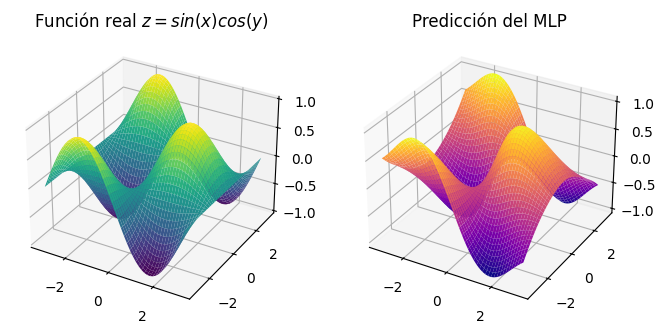

In [9]:
# =============================
# Predicción y Visualización
# =============================
import matplotlib.pyplot as plt

# Crear datos de prueba (rejilla)
x_test = np.linspace(-np.pi, np.pi, 50)
y_test = np.linspace(-np.pi, np.pi, 50)
X1, Y1 = np.meshgrid(x_test, y_test)
X_test = np.stack([X1.ravel(), Y1.ravel()], axis=1)
Z_true_test = np.sin(X_test[:,0]) * np.cos(X_test[:,1])

# Predicciones con la red
Z_pred_test = predict(X_test, params, activations).flatten()

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(8,5), subplot_kw={"projection":"3d"})

axs[0].plot_surface(X1, Y1, Z_true_test.reshape(X1.shape), cmap="viridis")
axs[0].set_title("Función real $z = sin(x)cos(y)$")

axs[1].plot_surface(X1, Y1, Z_pred_test.reshape(X1.shape), cmap="plasma")
axs[1].set_title("Predicción del MLP")

plt.show()

## 5. Ejemplo compacto con Keras

En la práctica, rara vez implementamos **forward** y **backward propagation** desde cero.
Frameworks como **Keras** (encima de TensorFlow) ya implementan estas operaciones de forma eficiente,
permitiendo enfocarnos en el diseño de la arquitectura y la experimentación.

Para entrenar un modelo con Keras es importante dividir los datos en dos conjuntos:

- **Train (entrenamiento)**: el modelo ajusta sus parámetros con este conjunto.  
- **Test (validación/prueba)**: se usa para evaluar qué tan bien generaliza el modelo a ejemplos que **no ha visto**.  

Esto previene el *overfitting*, que ocurre cuando la red "memoriza" los datos en lugar de aprender el patrón subyacente.  

En este ejemplo entrenamos un perceptrón multicapa (MLP) con Keras para aproximar nuestra función:

$$
z = \sin(x)\cos(y), \quad (x,y) \in [-\pi, \pi]^2
$$

usando la misma arquitectura e hiperparámetros con que hemos implementado antes la red.



In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Usar los datos ya generados en la sección anterior: (X, Z_true)
X_train, X_test, Y_train, Y_test = train_test_split(X, Z_true, test_size=0.2, random_state=42)

# Definir arquitectura
model = keras.Sequential([
    layers.Input(shape=(2,)),              # entrada (x,y)
    layers.Dense(32, activation="tanh"),   # primera capa oculta
    layers.Dense(16, activation="tanh"),   # segunda capa oculta
    layers.Dense(1, activation="linear")   # salida (regresión)
])

# Compilar modelo con mismos hiperparámetros
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss="mse",
              metrics=["mae"])

# Entrenar modelo
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4102 - mae: 0.5174 - val_loss: 0.1896 - val_mae: 0.3707
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1270 - mae: 0.2934 - val_loss: 0.0655 - val_mae: 0.2136
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - mae: 0.2008 - val_loss: 0.0312 - val_mae: 0.1430
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298 - mae: 0.1437 - val_loss: 0.0176 - val_mae: 0.1086
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - mae: 0.1101 - val_loss: 0.0134 - val_mae: 0.0942
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - mae: 0.0984 - val_loss: 0.0118 - val_mae: 0.0866
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - mae: 0.0914 - val_loss: 0.0115 - val_mae: 0.0852
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - mae: 0.0898 - val_loss: 0.0124 - val_mae: 0.0892
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - mae:

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


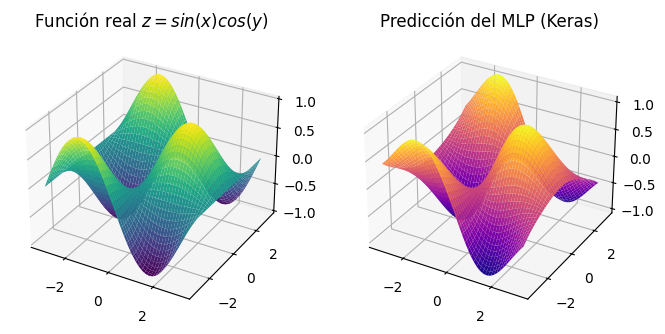

In [12]:
# =============================
# Visualización de predicciones
# =============================
x_test = np.linspace(-np.pi, np.pi, 50)
y_test = np.linspace(-np.pi, np.pi, 50)
X1, Y1 = np.meshgrid(x_test, y_test)
X_grid = np.stack([X1.ravel(), Y1.ravel()], axis=1)

Z_true_grid = np.sin(X_grid[:,0]) * np.cos(X_grid[:,1])
Z_pred_grid = model.predict(X_grid).flatten()

fig, axs = plt.subplots(1, 2, figsize=(8,5), subplot_kw={"projection":"3d"})

axs[0].plot_surface(X1, Y1, Z_true_grid.reshape(X1.shape), cmap="viridis")
axs[0].set_title("Función real $z = sin(x)cos(y)$")

axs[1].plot_surface(X1, Y1, Z_pred_grid.reshape(X1.shape), cmap="plasma")
axs[1].set_title("Predicción del MLP (Keras)")

plt.show()

La implementación manual con **NumPy** logra aproximar bien la función objetivo, alcanzando al final del entrenamiento una pérdida promedio de **MSE ≈ 0.0066**. Por su parte, el modelo en **Keras** obtuvo **MSE ≈ 0.0036** en entrenamiento y **≈ 0.0031** en validación, lo que representa una reducción de la pérdida de alrededor de un **46–53%**. Además, el modelo en Keras reportó un **MAE ≈ 0.0436** en entrenamiento y **≈ 0.0419** en validación, mostrando un ajuste más preciso y estable. Esto confirma que ambos enfoques capturan la función subyacente, pero Keras, gracias a su optimizador y manejo interno del entrenamiento, logra mejores métricas y una superficie predicha más suave, mientras que NumPy resulta valioso para comprender en detalle cada paso del algoritmo.


## Conclusiones

El perceptrón multicapa es, en esencia, una función compuesta que combina operaciones lineales y no lineales para aproximar relaciones complejas entre datos. Con el *forward propagation* vimos cómo fluye la información capa a capa, y con el *backpropagation* entendimos cómo los gradientes permiten ajustar los parámetros mediante optimización. Implementarlo con NumPy nos dio una visión clara de las entrañas del proceso, mientras que Keras mostró la potencia de los frameworks modernos al abstraer esos cálculos.

Lo aprendido aquí constituye la base sobre la que se construyen arquitecturas más avanzadas de redes neuronales: entender cómo funciona un MLP no es el final, sino el primer paso hacia modelos cada vez más sofisticados y aplicados en problemas del mundo real.